Minimum number of pixels for an error rate <= 0.1: 2


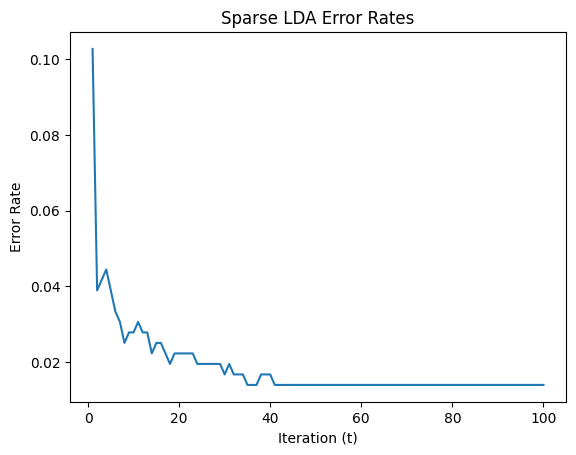

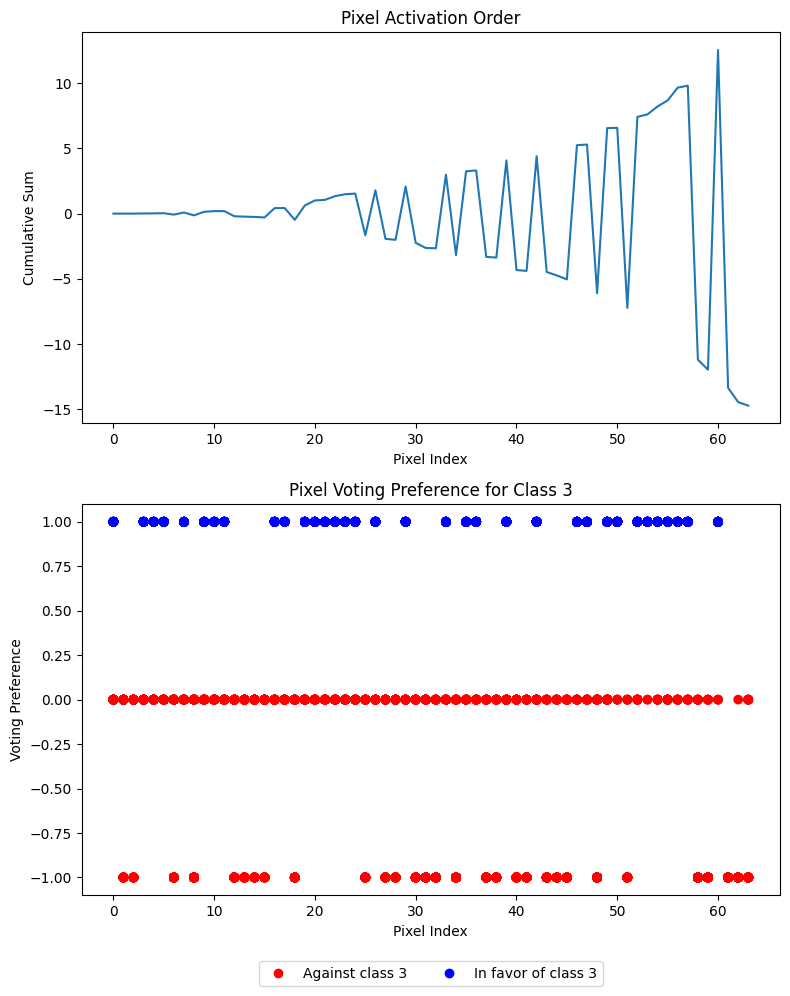

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def omp_regression(X, y, T):
    N, D = X.shape
    A = set()
    B = set(range(D))
    solutions = np.zeros((D, T))

    r = y
    for t in range(T):
        max_corr = -np.inf
        best_col = None

        for j in B:
            corr = np.abs(X[:, j].T @ r)
            if corr > max_corr:
                max_corr = corr
                best_col = j

        if best_col in B:  
            A.add(best_col)
            B.remove(best_col)  

        X_active = X[:, list(A)]
        beta_t = np.linalg.lstsq(X_active, y, rcond=None)[0]
        solutions[list(A), t] = beta_t

        r = y - X_active @ beta_t

    return solutions


# Step 1: Load and preprocess the dataset
digits = load_digits()
X = digits.images.reshape(len(digits.images), -1)
y = np.where(digits.target == 3, 1, -1)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Step 3: Perform sparse LDA using OMP
T = 100  # Set a sufficiently large T value

# Apply OMP regression
N, D = X_train.shape
A = set()
B = set(range(D))
solutions = np.zeros((D, T))

r = y_train
for t in range(T):
    max_corr = -np.inf
    best_col = None

    for j in B:
        corr = np.abs(X_train[:, j].T @ r)
        if corr > max_corr:
            max_corr = corr
            best_col = j

    if best_col in B: 
        A.add(best_col)
        B.remove(best_col) 

    X_active = X_train[:, list(A)]
    beta_t = np.linalg.lstsq(X_active, y_train, rcond=None)[0]
    solutions[list(A), t] = beta_t

    r = y_train - X_active @ beta_t

# Step 4: Analyze the results
error_rates = []
selected_pixels = []
voting_preference = np.zeros((D, T), dtype=int)  # Initialize the voting_preference array

for t in range(T):
    selected_features = np.nonzero(solutions[:, t])[0]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    # Fit LDA model and make predictions
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_selected, y_train)
    y_pred = lda.predict(X_test_selected)

    # Calculate the classification error rate
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)
    selected_pixels.append(len(selected_features))

    # Calculate the pixel voting preference for class '3'
    beta = solutions[selected_features, t]
    pixel_voting_preference = np.sign(beta)
    voting_preference[selected_features, t] = pixel_voting_preference




# Finding the number of pixels for acceptable error rates
acceptable_error_rate = 0.1  # Set your acceptable error rate threshold
acceptable_pixels = [p for p, error in zip(selected_pixels, error_rates) if error <= acceptable_error_rate]
if acceptable_pixels:
    min_acceptable_pixels = min(acceptable_pixels)
    print(f"Minimum number of pixels for an error rate <= {acceptable_error_rate}: {min_acceptable_pixels}")
else:
    print("No acceptable error rates found.")
# Visualization: Error rates for each iteration   
plt.plot(range(1, T+1), error_rates)
plt.xlabel('Iteration (t)')
plt.ylabel('Error Rate')
plt.title('Sparse LDA Error Rates')
plt.show()

# Visualization: Pixel order and voting preference
pixel_order = np.argsort(np.abs(solutions.sum(axis=1)))  # Order of pixels switched to active

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot the order in which pixels are shifted to active
ax[0].plot(range(D), solutions.sum(axis=1)[pixel_order])
ax[0].set_xlabel('Pixel Index')
ax[0].set_ylabel('Cumulative Sum')
ax[0].set_title('Pixel Activation Order')

# Plot the voting preference for class '3'
for i in range(T):
    voting_pref = voting_preference[:, i][pixel_order]
    non_zero_indices = np.nonzero(voting_pref)  # Get the indices where voting preference is non-zero
    colors = np.where(voting_pref > 0, 'b', 'r')  # Set color blue for voting in favor and red for voting against
    ax[1].scatter(range(D), voting_pref, c=colors)

ax[1].set_xlabel('Pixel Index')
ax[1].set_ylabel('Voting Preference')
ax[1].set_title('Pixel Voting Preference for Class 3')

# Add color legend
against_patch = plt.Line2D([], [], color='r', marker='o', linestyle='', label='Against class 3')
in_favor_patch = plt.Line2D([], [], color='b', marker='o', linestyle='', label='In favor of class 3')
ax[1].legend(handles=[against_patch, in_favor_patch], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()
